# NBA Spatial Data

I obtained a dataset that tracks the location of the ball and each player on the court every 0.04 seconds in a game. It covers about 700 NBA games from Oct 2015 to Jan 2016. The size of the dataset is 60GB. 

In [71]:
import json, imp
import pandas as pd
import matplotlib.pyplot as plt
import bball, sqlite3, math
import seaborn as sns
import statsmodels.formula.api as sm
import scipy
from statsmodels.nonparametric.smoothers_lowess import lowess
#allow graphs to be shown in ipython notebook
%matplotlib inline

I'm interested whether fatigue would cause players to slow down in the game. 

I cannot measure players' fatigue directly. But I assume that players' speed would fall down as their fatigue increases; I also believe that they get more tired as the game goes on. Therefore I can instead look at the relationship between speed and time.

For each game, I caculated speed at each moment when the game is going on, and removed unreasonable observations.  

There are several choices for time variable. Since players don't get tired when they take a break or there is a time out, I chose time on court as the time variable.  

There are almost 1 billion observations for speed. I downsampled the dataset by taking the average of the speed within a short time (1 sec in my case). 

I saved the results into a database. 

In [2]:
#db_filename = '/Volumes/lu/basketball.sqlite'
#db_filename = '/Volumes/Seagate Expansion Drive/bball/basketball.sqlite'
db_filename = '/Volumes/bball/bball'
connection = sqlite3.connect(db_filename)
players = pd.read_sql('SELECT * FROM players', connection)
players = players.set_index('player_id')
downsample_spatial = pd.concat(pd.read_sql('SELECT * FROM downsampled_spatial_1_0', connection, chunksize=1000000),
                               ignore_index=True)
downsample_spatial.dropna(subset=['speed'], inplace=True)
del connection

In [67]:
downsample_spatial.rename(columns={'time_in_game':'time_on_court'}, inplace=True)
def speed_transform(downsampled_spatial, min_obs): 
    grouped_speeds = downsampled_spatial.groupby('time_on_court')
    speed = grouped_speeds['speed'].mean()
    valid_speed = grouped_speeds.size() > min_obs
    return speed[valid_speed].reset_index()
avg_speed = speed_transform(downsample_spatial, 100)

## Analysis of Fatigue

The scatter plot of speed vs time. It's too dense to see anything.

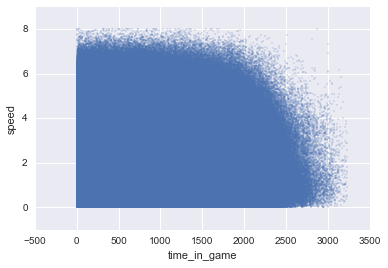

In [29]:
sns.regplot(downsample_spatial['time_on_court'],downsample_spatial['speed'], fit_reg=False, scatter_kws={'s': 1})

Now I sample 0.001 fraction of the dataset. R^2 is so small that we cannot see anything interesting either. 

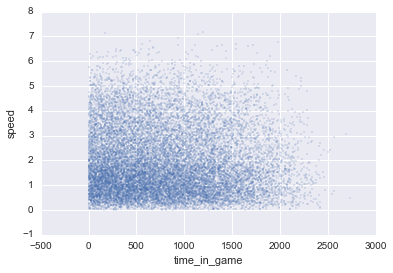

In [40]:
sampled = downsample_spatial[['time_on_court', 'speed']].sample(frac=0.001)
sns.regplot('time_on_court', 'speed', data=sampled, fit_reg=False, scatter_kws={'s': 1})

The density functions of the speed of early time on court and of late time on court. We can see there are more oberservations of high speed (3-5 m/s) and fewer observations of low speed (below 2 m/s) at early time on court.

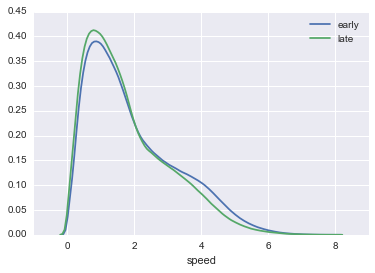

In [39]:
times = downsample_spatial['time_on_court']
sns.distplot(downsample_spatial.loc[times<500, 'speed'], hist=False, label='early')
sns.distplot(downsample_spatial.loc[times>1500, 'speed'], hist=False, label='late')

A scatterplot of time vs. average speed (averaged for each time point). We see there is an approximately linear relationship (negative) between them. 

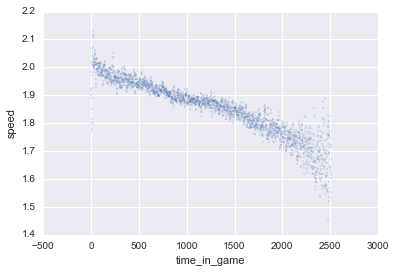

In [28]:
sns.regplot(avg_speed['time_on_court'],avg_speed['speed'], fit_reg=False, scatter_kws={'s': 1})

It looks very promising from the graph above, but I want to test whether there is any correlation between speed and time on court using Student's t-distribution. Here I use spearman's rank correlation coefficient and get a significant p-value under null hypothesis that the correlation is 0. 

In [82]:
spearman_corr = scipy.stats.spearmanr(downsample_spatial[['time_on_court', 'speed']])[0]
n = downsample_spatial.shape[0]
t_stat = spearman_corr* ((n-2)/(1-spearman_corr**2))**0.5
scipy.stats.t.cdf(t_stat, n-2)

0.0

Since the relationship between speed and time on court is roughly linear, I run linear regression on them to look at the slope. It tells us that speed approximately falls 0.0001 m/s every second that players are on court. 

Intercept       1.997447
time_in_game   -0.000110
dtype: float64

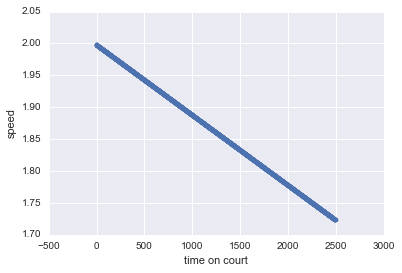

In [51]:
lr = sm.ols('speed ~ time_on_court', data=downsample_spatial).fit()
x = pd.DataFrame({'time_on_court': range(2500)})
est_y = lr.predict(x)
ax = sns.regplot(x,est_y, fit_reg=False)
ax.set_xlabel('time on court')
ax.set_ylabel('speed')
lr.params

## Confounding Variables

Now I want to look at other factors that might make players' speed fall.

First, it's possible that the relationship happens because faster players only play for a short time, but slower players play for a long time. 
If this is true, the relationship between speed and time for each player should be random. 
I exclude players without enough observations. Then I run linear regression for each player separately.
Here is the histogram and boxplot of all the slopes. 
Both graphs tell us that the relationship is negative except for several outliers. 

players with positive slope
Solomon Hill 4.82818315801e-05
Anderson Varejao 7.37324397982e-05
Luke Babbitt 3.03272103485e-05


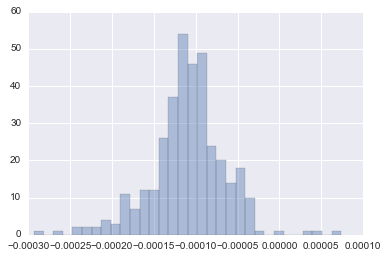

In [74]:
slopes = []
print('players with positive slope')
for player_id in players.index:
    player_avg_speed = downsample_spatial[downsample_spatial['player_id']==player_id]
    # maybe one player's obersvations at one point are too few
    if player_avg_speed.shape[0] < 10000:
        continue
    slope = sm.ols('speed ~ time_on_court', data=player_avg_speed).fit().params.iloc[1]   
    if slope > 0:
        print(players.loc[player_id, 'name'], slope)
    slopes.append(slope)
sns.distplot(slopes, kde=False)

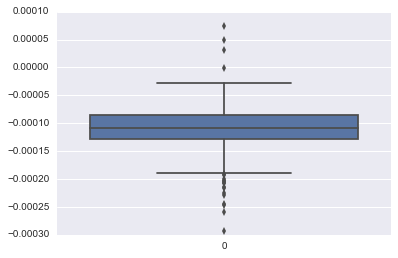

In [27]:
sns.boxplot(data=slopes)

Second, the relationship may be due to the change of strategy, for example the coach may ask players to pass more instead of fast break later in the game. 
I think that strategy would change by clock time in the game instead of the time players spend on court. 
If this is true, the relationship between speed and time on court should be random within a short clock time when the strategy changes little (but time on court still changes significantly because players join the game at different time). 
Here is the scatter plot of time on court and average speed at each court time point within 300 seconds of clock time.
Most graphs show negatively linear relationships, which means that this confounding variable is not a problem.

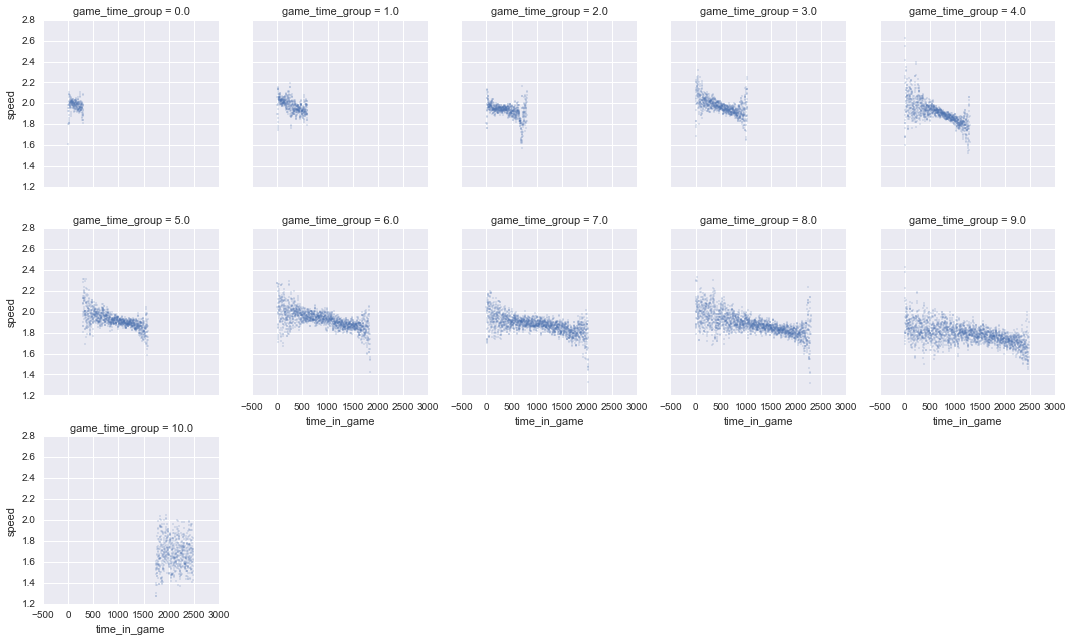

In [60]:
downsample_spatial['game_time_group'] = downsample_spatial['downsampled_game_time']//300
grouped_times = downsample_spatial.groupby(['game_time_group','time_on_court'])
speed = grouped_times['speed'].mean()
valid_speed = grouped_times.size() > 50
g = sns.FacetGrid(speed[valid_speed].reset_index(), col='game_time_group', col_wrap=5)
g.map(sns.regplot, 'time_on_court', 'speed', fit_reg=False, scatter_kws={'s': 1})

## More Analysis by Visualizations

### Lowess Speed vs. Time on Court 

Lowess uses average downsampled speed, which makes the end of smoothed line shifted down because there are fewer obersavtions with bigger time_on_court. 

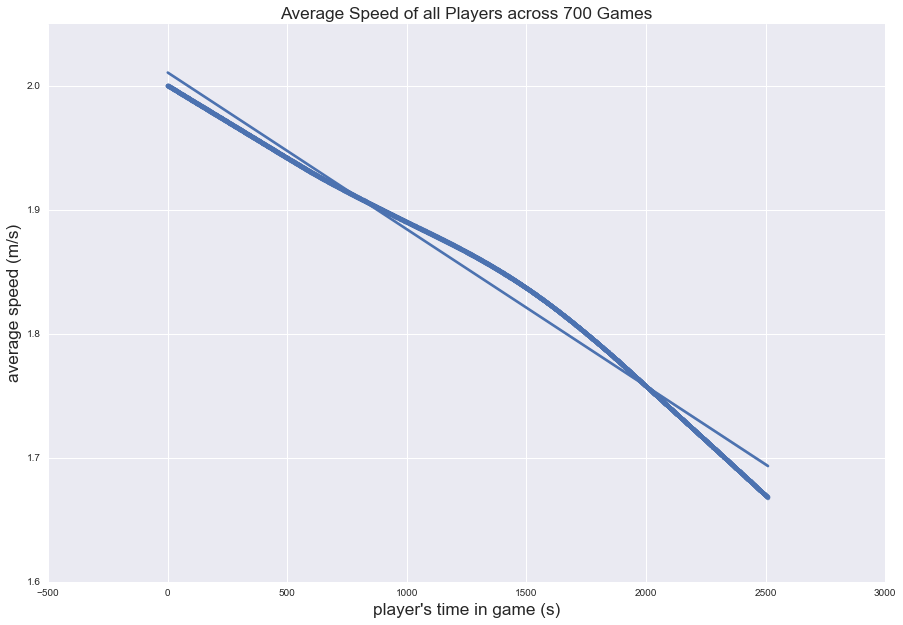

In [4]:
def smooth_plot(x, y, frac = 0.1, **kwargs):
    l = lowess(y, x, frac= frac)
    x = l[:,0]
    est_y = l[:,1]   
    return sns.regplot(x=x, y=est_y, **kwargs )

plt.figure(figsize=(15, 10))    
# plt.autoscale(tight=True)
ax = smooth_plot(avg_speed['time_on_court'],avg_speed['speed'], frac=0.05, truncate=True)
ax.set_xlabel("player's time in game (s)", fontdict={'fontsize': 'xx-large'})
ax.set_ylabel('average speed (m/s)', fontdict={'fontsize': 'xx-large'})
ax.set_title('Average Speed of all Players across 700 Games', fontsize='xx-large')

### Smoothed Speed of all Players in One Game

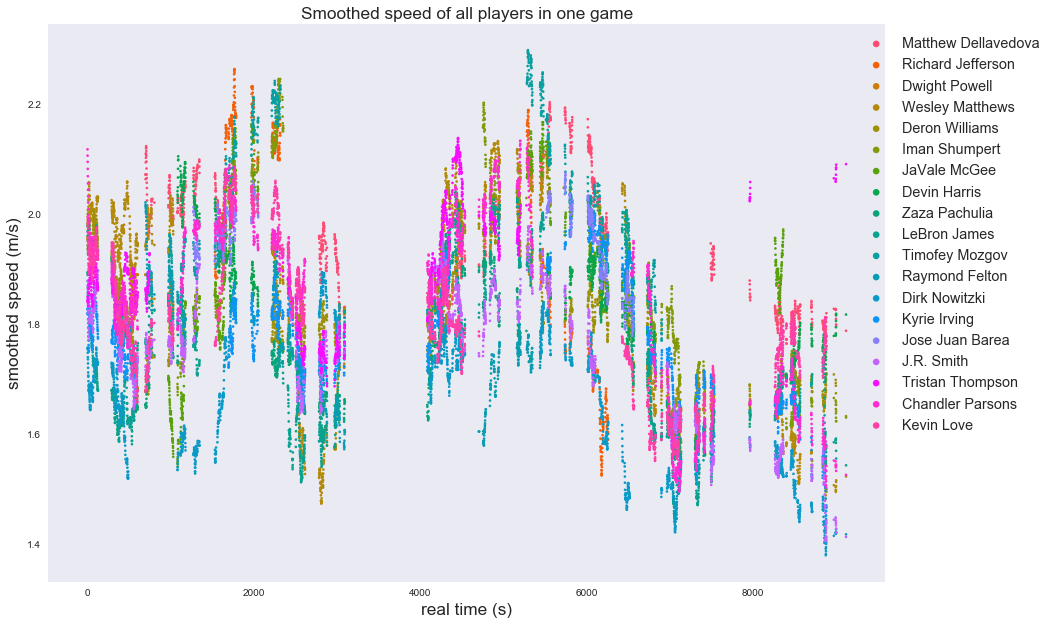

In [3]:
fig, ax = plt.subplots(figsize=(15, 10))
game = downsample_spatial[downsample_spatial['game_id'] == 21500575].copy()
game['real_time'] *= 1e-3
player_ids = set(game['player_id'])
colors = sns.husl_palette(n_colors=len(player_ids), s=1, l=0.6)
plt.autoscale(tight=True)
for i,player_id in enumerate(player_ids):   
    player_speed = game.loc[game['player_id'] == player_id,['real_time', 'speed']]
    rolling_player_speed = player_speed['speed'].rolling(window=300, center = True, min_periods=0).mean()
    player_speed['smoothed_speed'] = rolling_player_speed
    player_speed.plot(x ='real_time', y='smoothed_speed', color=colors[i], grid=False, edgecolors='none', 
                      kind='scatter', s=7, legend = False,  ax = ax)
ax.set_ylabel('smoothed speed (m/s)', fontdict={'fontsize': 'xx-large'})
ax.set_xlabel('real time (s)', fontdict={'fontsize': 'xx-large'})
ax.legend(players.loc[player_ids, 'name'],bbox_to_anchor=(1.2, 1.0),loc =1, fontsize='x-large', markerscale=2.5)
ax.set_title('Smoothed speed of all players in one game', fontsize='xx-large')

### Speed Distribution over all Players and Games

c:\users\moroz\appdata\local\programs\python\python35\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


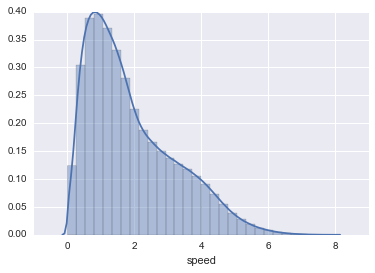

In [8]:
sns.distplot(downsample_spatial['speed'], bins=30)

In [10]:
def plot_player_spatial(player_id, connection, game_id=None, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    player_id = int(player_id.iloc[0])
    if game_id is None:
        player_spatial = pd.concat(pd.read_sql('SELECT * FROM spatial WHERE player_id=? AND speed NOT NULL', 
                                              params= [player_id], con=connection, chunksize=1000000), ignore_index=True)
    else:
        player_spatial = pd.read_sql('SELECT * FROM spatial WHERE player_id=? AND game_id=? AND speed NOT NULL', 
                                    params= [player_id, game_id], con=connection)

    first_half = player_spatial['cum_game_time'] < 1440
    second_half = ~first_half 
    rectangle_left = ((player_spatial['x']-5.25).abs()<30) & ((player_spatial['y']-25).abs()<10)
    rectangle_right = ((player_spatial['x']-88.75).abs()<30) & ((player_spatial['y']-25).abs()<10)
    for game_id in set(player_spatial['game_id']):
        game = (player_spatial['game_id'] == game_id)
        # defense should be always on the left side
        if (rectangle_left&first_half&game).sum() > (rectangle_right&first_half&game).sum():
            flip_side = second_half
        else:        
            flip_side = first_half
        player_spatial.loc[flip_side&game, 'x'] = 94 - player_spatial.loc[flip_side&game, 'x']
        player_spatial.loc[flip_side&game, 'y'] = 50 - player_spatial.loc[flip_side&game, 'y']
    
    
    colormap = sns.cubehelix_palette(as_cmap=True, rot=-0.5, start=0.15, dark=0, light=1,reverse=False)
    plt.hexbin(x=player_spatial['x'], y=player_spatial['y'], gridsize=40, cmap=colormap, axes=ax)
    #plt.colorbar()
    court = plt.imread('fullcourt.png')
    ax.imshow(court, zorder=1, extent=[0,94, 50, 0])
    ax.set_xlim([-10,104])
    ax.set_ylim([60,-10])
    ax.grid(False)

### Position Heat Map (Defense on the left)

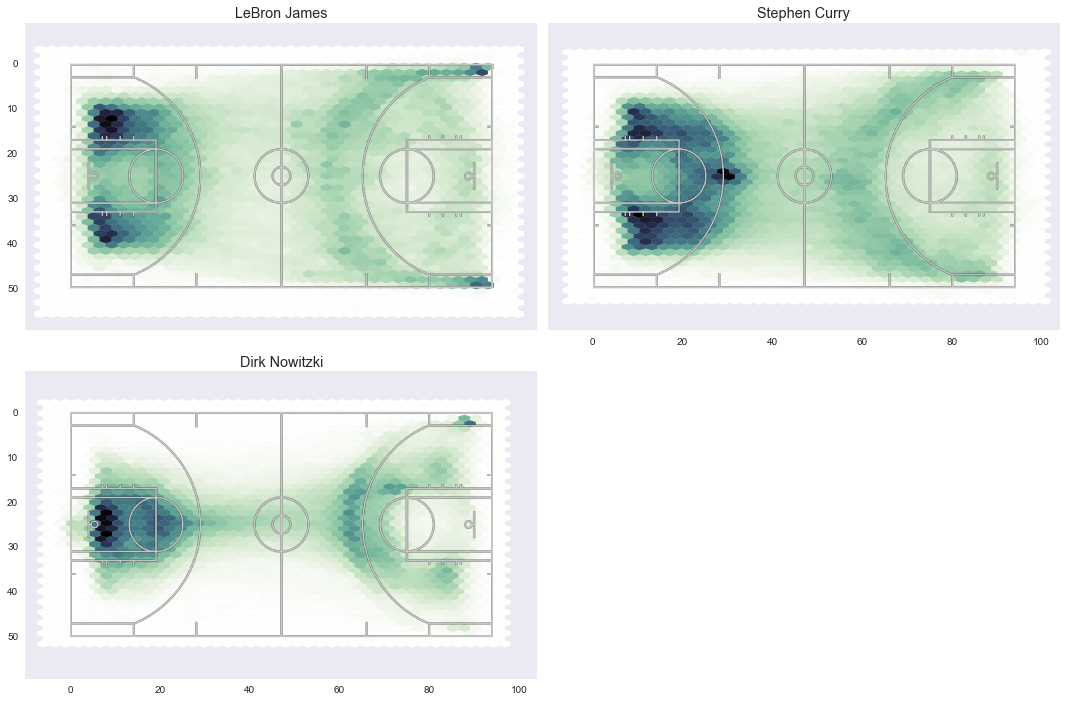

In [59]:
player_ids = [2544, 201939, 1717]
g = sns.FacetGrid(players.loc[player_ids].reset_index(), col='name', aspect=1.5, col_wrap=2, size=5)
g.map(plot_player_spatial,
      'player_id', 
      connection=connection)
g.set_titles("{col_name}", size='xx-large')
g.set_xlabels('')

### Average Speed over Games of Stephen Curry

In [101]:
def plot_player_avg_speed(player_id, downsample_spatial):
    fig, ax = plt.subplots(figsize=(15, 10))
    curry = downsample_spatial[downsample_spatial['player_id'] == player_id]
    groups = curry.groupby('time_on_court')
    curry_avg = groups['speed'].mean()
    curry_avg.name = 'average speed'
    speed_ax = curry_avg.plot(legend=True)
    num = groups.size()
    num.name = 'number of games'
    num_ax = num.plot(secondary_y=True, legend=True)
    num_ax.set_ylabel('number of games', fontdict={'fontsize': 'xx-large'})
    speed_ax.grid(False)
    speed_ax.set_title('Average Speed of Steph Curry over Games', fontsize='xx-large')
    speed_ax.set_ylabel('speed (m/s)', fontdict={'fontsize': 'xx-large'})
    speed_ax.set_xlabel('time in game (s)', fontdict={'fontsize': 'xx-large'})

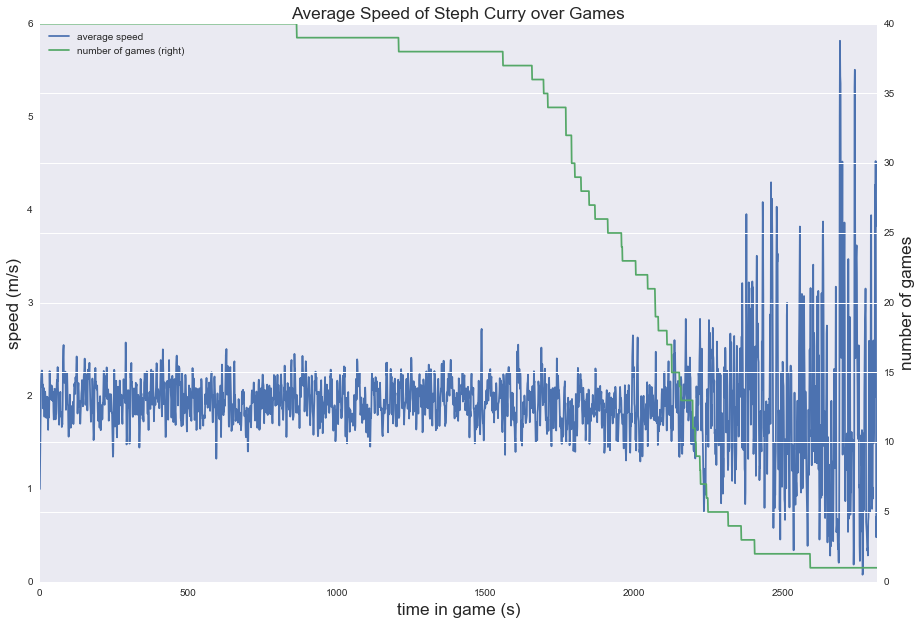

In [102]:
plot_player_avg_speed(201939, downsample_spatial)